In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

import timeit

# Load data

In [2]:
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=0.005)

In [3]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  30
num_train_unlabled:  270
num_test:  50


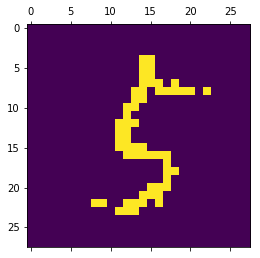

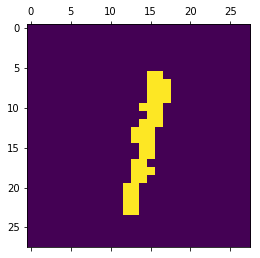

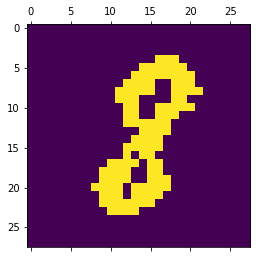

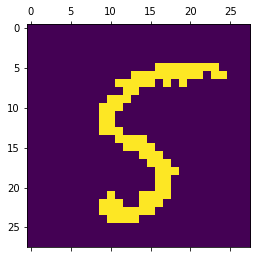

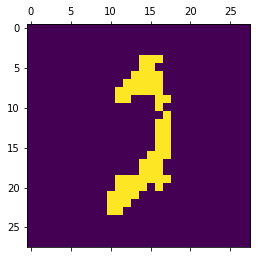

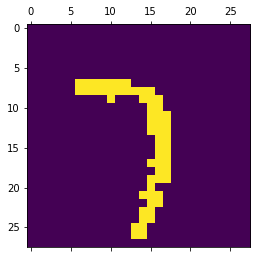

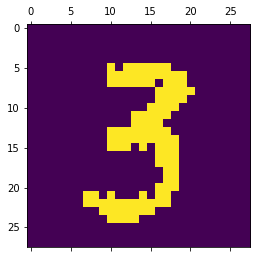

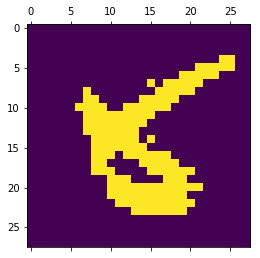

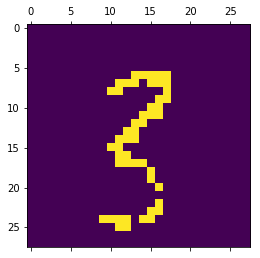

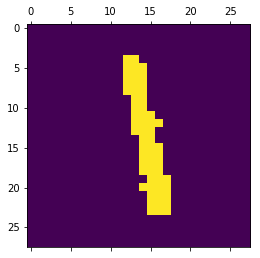

In [4]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())

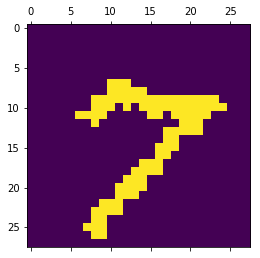

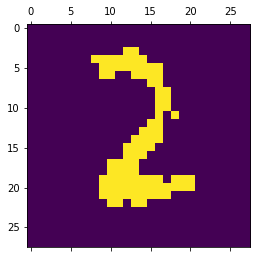

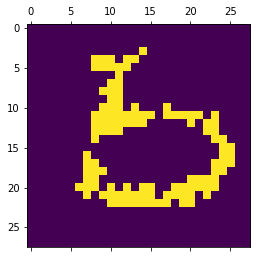

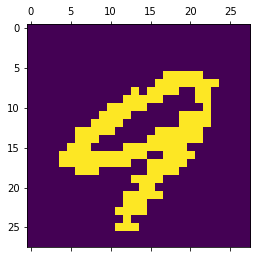

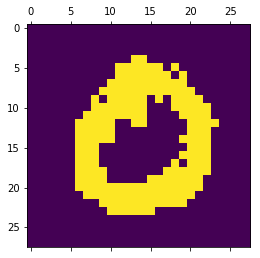

In [5]:
for i in range(5): 
    plt.matshow(test_set[i]['image'].squeeze())

In [6]:
slen = train_set_unlabeled[0]['image'].shape[0]

# Get data loaders

In [7]:
batchsize = 8

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [8]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [9]:
data_unlabeled['image'].shape

torch.Size([8, 28, 28])

# Define VAE

In [10]:
latent_dim = 5
n_classes = 10

In [11]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [12]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=10, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)>


In [13]:
28 * 28

784

In [14]:
2 * 28 * 28

1568

In [15]:
### Check things run

In [16]:
num_unlabled = train_loader_unlabeled.sampler.data_source.num_images

In [17]:
vae.get_semisupervised_loss(data_unlabeled['image'], num_unlabled,
                                    labeled_images = data_labeled['image'], labels = data_labeled['label'],
                                    alpha = 1.0, reinforce = True)

z_sample tensor([ 3,  9,  9,  7,  6,  1,  0,  0])
tensor(-18.3765)


(tensor(1.00000e+05 *
        1.5050), tensor(1.00000e+06 *
        -1.4711), tensor(541.2209), tensor(543.7257), tensor(2.2640))

# Check gradient works 

In [18]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [19]:
vae_params0 = get_vae_params(vae)

In [20]:
assert np.any(np.isnan(vae_params0)) == False

In [21]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [22]:
loss, ps_loss, _, _, _ = vae.get_semisupervised_loss(data_unlabeled['image'], num_unlabled,
                                    labeled_images = data_labeled['image'], labels = data_labeled['label'],
                                    alpha = 1.0, reinforce = True)

z_sample tensor([ 8,  1,  8,  9,  4,  2,  0,  8])
tensor(-18.3765)


In [23]:
loss.backward()
optimizer.step()

In [24]:
vae_params1 = get_vae_params(vae)

In [25]:
assert np.any(np.isnan(vae_params1)) == False

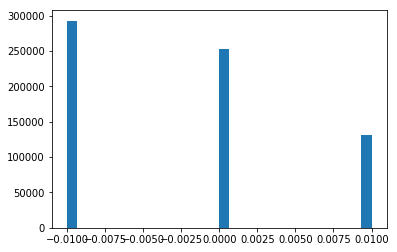

In [26]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [27]:
loss, ps_loss, _, _, _ = vae.get_semisupervised_loss(data_unlabeled['image'], num_unlabled,
                                    labeled_images = data_labeled['image'], labels = data_labeled['label'],
                                    alpha = 1.0, reinforce = True)

z_sample tensor([ 8,  7,  6,  7,  4,  1,  8,  6])
tensor(-13.3301)


In [28]:
assert np.isfinite(loss.detach().numpy())

In [29]:
train_loader_unlabeled.dataset.__len__()

270

In [30]:
mnist_vae_lib.train_semisupervised_model(vae, train_loader_unlabeled, data_labeled['image'], data_labeled['label'], 
                    test_loader, n_epoch = 5, print_every = 2, outfile = './test', reinforce = True)

  * init train recon loss: 441.5501709;
  * init test recon loss: 440.6095276;
  * init train class accuracy: 0.1;
  * init test class accuracy: 0.06;
z_sample tensor([ 7,  8,  7,  4,  8,  5,  8,  8])
tensor(-14.3843)
z_sample tensor([ 8,  8,  1,  8,  8,  8,  3,  6])
tensor(-15.4327)
z_sample tensor([ 0,  6,  4,  6,  6,  6,  8,  6])
tensor(-16.1481)
z_sample tensor([ 3,  2,  4,  7,  7,  0,  2,  3])
tensor(-16.6274)
z_sample tensor([ 0,  1,  2,  7,  7,  7,  8,  6])
tensor(-16.5746)
z_sample tensor([ 3,  7,  6,  8,  2,  4,  6,  0])
tensor(-16.5110)
z_sample tensor([ 4,  8,  5,  0,  3,  0,  0,  6])
tensor(-16.5975)
z_sample tensor([ 3,  7,  7,  6,  4,  7,  8,  8])
tensor(-16.2524)
z_sample tensor([ 4,  7,  2,  4,  3,  0,  8,  6])
tensor(-16.5530)
z_sample tensor([ 8,  7,  6,  7,  6,  0,  3,  3])
tensor(-15.1373)
z_sample tensor([ 4,  3,  7,  3,  7,  8,  8,  4])
tensor(-16.2963)
z_sample tensor([ 9,  7,  4,  8,  0,  7,  2,  7])
tensor(-15.4353)
z_sample tensor([ 1,  6,  3,  6,  7,  6,  4, 

In [31]:
image = data_unlabeled['image']

In [32]:
class_weights = vae.classifier(image)

In [33]:
from torch.distributions import Normal, Categorical

In [34]:
# probs = torch.Tensor([[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
probs = class_weights

In [35]:
cat_rv = Categorical(probs = probs)

In [36]:
z_sample = cat_rv.sample().detach()

In [37]:
z_sample

tensor([ 9,  4,  4,  4,  4,  8,  9,  0])

In [38]:
z = 8

In [39]:
mask = np.zeros(len(z_sample))
mask[z_sample.cpu().numpy() == z] = 1

In [40]:
mask

array([0., 0., 0., 0., 0., 1., 0., 0.])

In [41]:
vae.get_conditional_loss(image, 4)

tensor([ 194.4832,  275.9522,  213.8683,  195.8459,  203.3326,  231.7327,
         277.3634,  217.6904])

In [42]:
class_weights.shape

torch.Size([8, 10])